# Clustering: Check-in analysis

## K-Means

### 1. Load and standarize data

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
user_features = pd.read_csv("../data/user_features.csv", index_col=0)
user_features = pd.get_dummies(user_features, columns=['time_of_day_preference'], drop_first=True)

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_features)

# Convert scaled data to df
user_features_scaled = pd.DataFrame(scaled_features, columns=user_features.columns, index=user_features.index)


### 2. Determining optimal number of clusters

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)

# Initalize scores
inertia_values = [] 
silhouette_scores = []

# For each k alculate inertia and silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_features_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(user_features_scaled, kmeans.labels_))

/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/

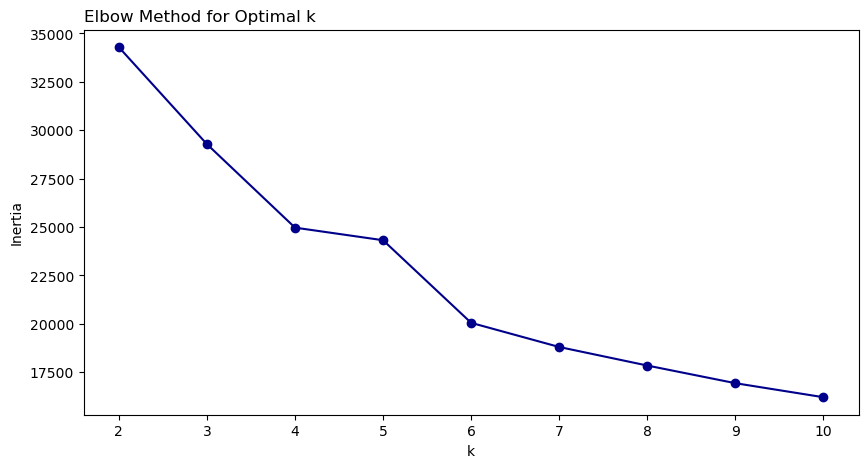

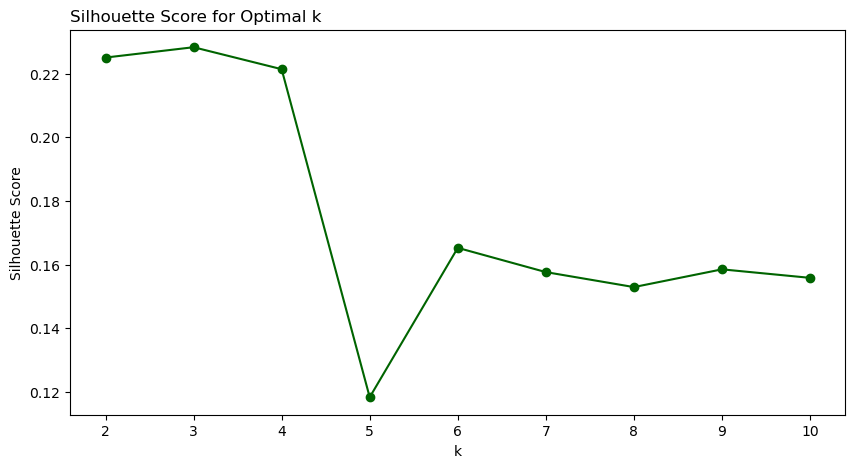

In [39]:
# Elbow
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', color="darkblue")
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k', loc="left")
plt.show()

# Silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='darkgreen')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k', loc="left")
plt.show()

### 3. K-means with optimal k

In [55]:
# Based on combination of above plots k = 4 is chosen for further analysis
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_features_scaled['cluster'] = kmeans.fit_predict(user_features_scaled)

# Add cluster labels to user_features df
user_features['kmeans_cluster'] = user_features_scaled['cluster']

/home/qingjies215090/anaconda3/envs/ml4proteins/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [56]:
cluster_summary = user_features.groupby('kmeans_cluster').mean()

# Display the summary
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
                checkin_frequency  workout_diversity  seasonal_variability  \
kmeans_cluster                                                               
0                        6.497723                6.0              2.586797   
1                        6.444599                6.0              2.595166   
2                        6.416485                6.0              2.557885   
3                        5.286675                5.0              1.971683   

                weekend_preference  avg_workout_duration  checkin_regularity  \
kmeans_cluster                                                                 
0                         0.289896            104.615487          118.192398   
1                         0.288270            104.274386          117.170023   
2                         0.288626            104.297942          118.817892   
3                         0.338936            105.754468          109.746351   

                time_of_day_prefe

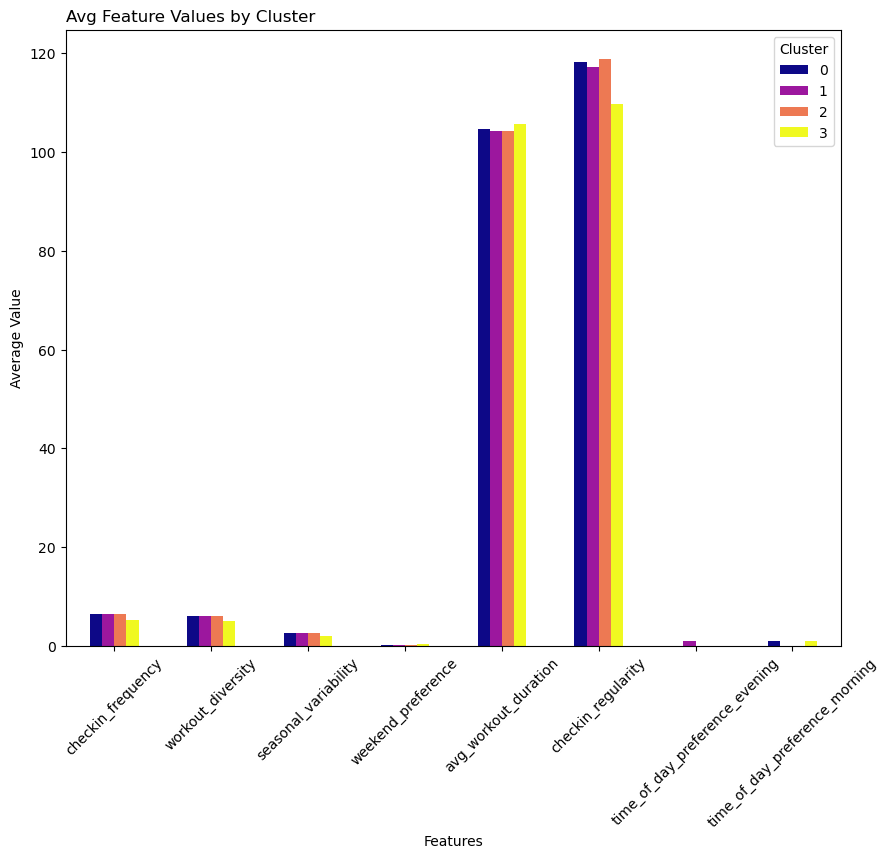

In [57]:
import matplotlib.pyplot as plt

# Plot average values of each feature for each cluster
cluster_summary.T.plot(kind='bar', figsize=(10, 8), cmap='plasma')
plt.title("Avg Feature Values by Cluster", loc="left")
plt.ylabel("Average Value")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()


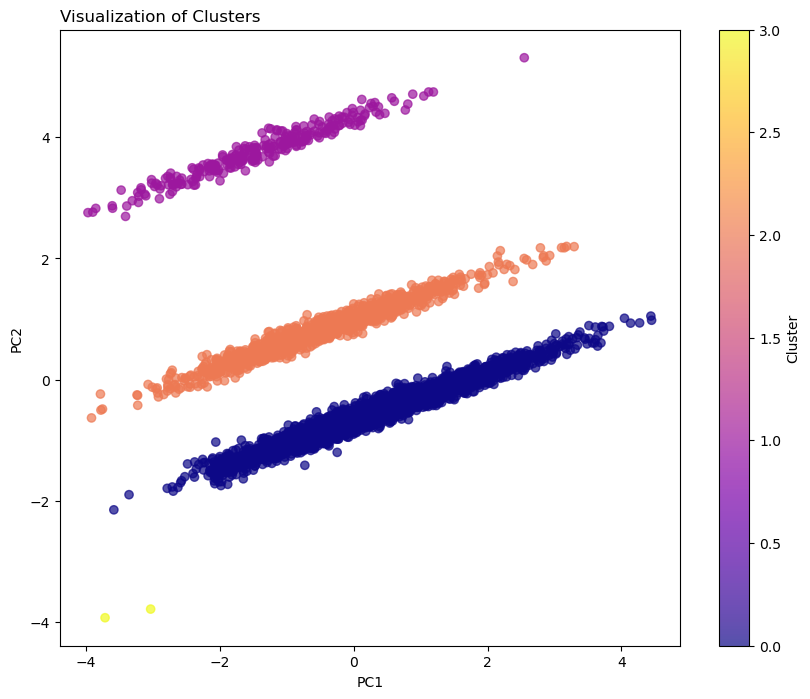

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(user_features_scaled.drop('cluster', axis=1))

# Plot clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=user_features_scaled['cluster'], cmap='plasma', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Clusters', loc="left")
plt.show()

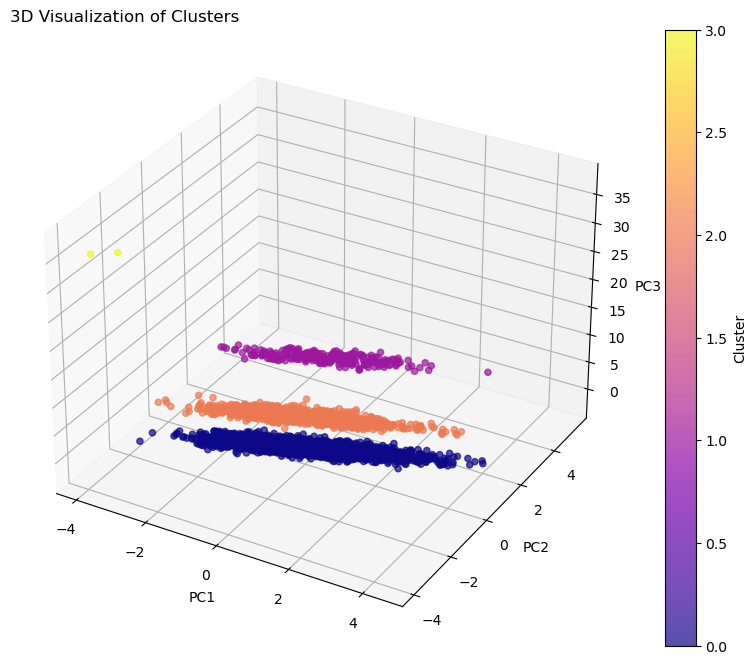

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(user_features_scaled.drop('cluster', axis=1))

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_components[:, 0], 
    pca_components[:, 1], 
    pca_components[:, 2], 
    c=user_features_scaled['cluster'], 
    cmap='plasma', 
    alpha=0.7
)

# Add labels and color bar
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Visualization of Clusters', loc="left")
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


In [60]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_avg = silhouette_score(user_features_scaled.drop('cluster', axis=1), user_features_scaled['cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")
db_index = davies_bouldin_score(user_features_scaled.drop('cluster', axis=1), user_features_scaled['cluster'])
print(f"Davies-Bouldin Index: {db_index:.3f}")

#Get poor scores, trying with DBSCAN instead

Silhouette Score: 0.221
Davies-Bouldin Index: 1.215


## DBSCAN

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# DBSCAN parameters
eps = 0.5  
min_samples = 5  

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(user_features_scaled)

# Add cluster labels to df
user_features_scaled['dbscan_cluster'] = dbscan_labels

# Filter out noise points
filtered_data = user_features_scaled[user_features_scaled['dbscan_cluster'] != -1]

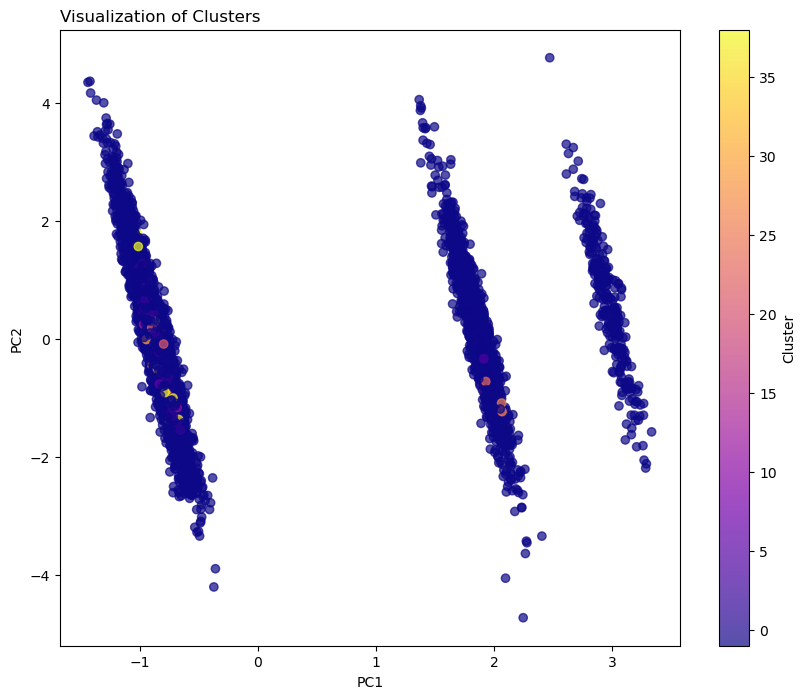

In [65]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(user_features_scaled.drop('dbscan_cluster', axis=1))

# Plot clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=user_features_scaled['dbscan_cluster'], cmap='plasma', alpha=0.7)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Clusters', loc="left")
plt.show()


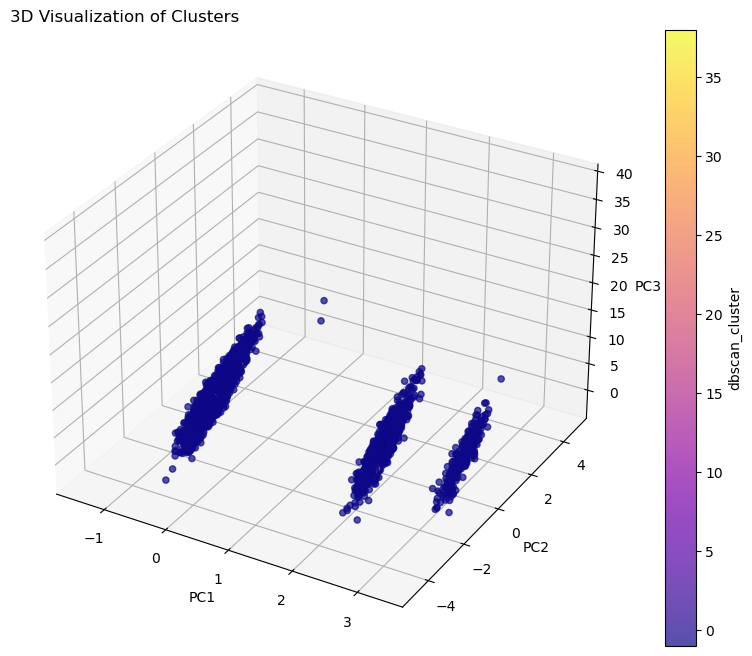

In [64]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(user_features_scaled.drop('dbscan_cluster', axis=1))

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_components[:, 0], 
    pca_components[:, 1], 
    pca_components[:, 2], 
    c=user_features_scaled['dbscan_cluster'], 
    cmap='plasma', 
    alpha=0.7
)

# Add labels and color bar
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Visualization of Clusters', loc="left")
fig.colorbar(scatter, ax=ax, label='dbscan_cluster')
plt.show()

In [67]:
# Calculate metrics
if len(filtered_data) > 0:
    silhouette_avg = silhouette_score(filtered_data.drop('dbscan_cluster', axis=1), filtered_data['dbscan_cluster'])
    db_index = davies_bouldin_score(filtered_data.drop('dbscan_cluster', axis=1), filtered_data['dbscan_cluster'])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Davies-Bouldin Index: {db_index:.3f}")
else:
    print("DBSCAN identified all points as noise; consider adjusting eps or min_samples.")

Silhouette Score: -0.068
Davies-Bouldin Index: 0.987
